In [1]:
import pandas as pd
import string
import re
import nltk
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dgdev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dgdev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dgdev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('data.csv')
df.dropna(inplace=True)
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']

In [52]:
df["Label"].value_counts()

1    1062
0     924
Name: Label, dtype: int64

In [3]:
X_train = train.iloc[:,2:27]
y_train = train["Label"]

In [4]:
for column in X_train.columns:
    X_train[column] = X_train[column].str.lstrip('b\'').str.lstrip('b"')

In [5]:
def caseLower(text) :
    text = text.lower()
    return text

def punctuationRemove(text) :
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub("[0-9]+", "", text)
    return text

def tokenization(text) :
    text = text.strip()
    text = re.split("\W+", text)
    return text

def singlesRemove(text) :
    text = [word for word in text if len(word) > 1]
    return text

def stopwordsRemove(text) :
    stopword = nltk.corpus.stopwords.words("english")
    text = [word for word in text if word not in stopword]
    return text

def lemmatizer(text) :
    text = [nltk.WordNetLemmatizer().lemmatize(word) for word in text]
    return text

def preprocess(text) :
    text = caseLower(text)
    text = punctuationRemove(text)
    text = tokenization(text)
    text = singlesRemove(text)
    text = stopwordsRemove(text)
    text = lemmatizer(text)
    text = " ".join(text)
    return text

In [6]:
for column in X_train.columns:
    X_train[column] = X_train[column].apply(lambda x: preprocess(x))

In [7]:
headlines = []
for row in range(0,len(X_train.index)):
    headlines.append(' '.join(str(x) for x in X_train.iloc[row,0:25]))

In [8]:
vectorizer = TfidfVectorizer(ngram_range=(2,2))
X_train = vectorizer.fit_transform(headlines)

In [9]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
test_transform = []
for row in range(0,len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_dataset = vectorizer.transform(test_transform)
predictions_mnb = mnb.predict(test_dataset)

In [12]:
predictions_knn = knn.predict(test_dataset)

In [44]:
print("-------------------Naive Bayes------------------")
cm_mnb = confusion_matrix(test["Label"], predictions_mnb)
report_mnb = classification_report(test["Label"], predictions_mnb)
print(format(report_mnb))

-------------------Naive Bayes------------------
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       186
           1       0.77      0.99      0.87       192

    accuracy                           0.85       378
   macro avg       0.88      0.84      0.84       378
weighted avg       0.88      0.85      0.84       378



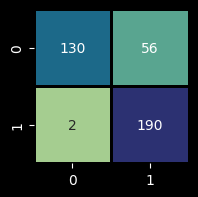

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("dark_background")
plt.figure(figsize=(2,2))
sns.heatmap(cm_mnb, annot=True, cmap="crest", linewidths=2, linecolor="black", cbar=False, fmt="d")
plt.show()

In [28]:
scores_mnb = {"precision": [], "recall": [], "f1-score": []}
lines = report_mnb.split('\n')
for line in lines[2:4]:  # Extract the lines containing class-wise precision values
    line = line.strip()
    cols = line.split()
    scores_mnb["precision"].append(float(cols[1]))
    scores_mnb["recall"].append(float(cols[2]))
    scores_mnb["f1-score"].append(float(cols[3]))

print(scores_mnb)

{'precision': [0.98, 0.77], 'recall': [0.7, 0.99], 'f1-score': [0.82, 0.87]}


In [36]:
print("------------------KNN------------------")
cm_knn = confusion_matrix(test["Label"], predictions_knn)
report_knn = classification_report(test["Label"], predictions_knn)
print(report_knn)

------------------KNN------------------
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       186
           1       0.66      0.65      0.65       192

    accuracy                           0.65       378
   macro avg       0.65      0.65      0.65       378
weighted avg       0.65      0.65      0.65       378



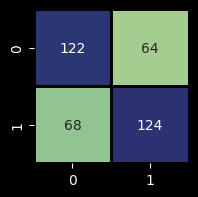

In [51]:
plt.figure(figsize=(2,2))
sns.heatmap(cm_knn, annot=True, cmap="crest", linewidths=2, linecolor="black", cbar=False, fmt="d")
plt.show()

In [30]:
scores_knn = {"precision": [], "recall": [], "f1-score": []}
lines = report_knn.split('\n')
for line in lines[2:4]:  # Extract the lines containing class-wise precision values
    line = line.strip()
    cols = line.split()
    scores_knn["precision"].append(float(cols[1]))
    scores_knn["recall"].append(float(cols[2]))
    scores_knn["f1-score"].append(float(cols[3]))

print(scores_knn)

{'precision': [0.64, 0.66], 'recall': [0.66, 0.65], 'f1-score': [0.65, 0.65]}


In [76]:
df["Label"].value_counts().values[0]

1062

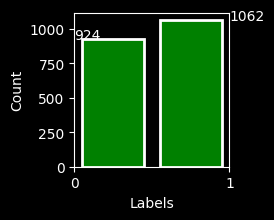

In [87]:
plt.figure(figsize=(2,2))
plt.hist(df["Label"], bins=2, color="green", edgecolor="white", linewidth=2, rwidth=0.8)
plt.xticks([0,1])
plt.xlabel("Labels")
plt.ylabel("Count")
for i in range(2) :
    if i==0 :
        plt.annotate(str(df["Label"].value_counts().values[i]), xy=(1, df["Label"].value_counts().values[i]))
    elif i==1 :
        plt.annotate(str(df["Label"].value_counts().values[i]), xy=(0, df["Label"].value_counts().values[i]))
plt.show()